<a href="https://colab.research.google.com/github/ykitaguchi77/Laboratory_course/blob/master/12.%20web%E3%82%A2%E3%83%97%E3%83%AA%E3%82%92%E4%BD%9C%E3%81%A3%E3%81%A6%E3%81%BF%E3%82%88%E3%81%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**機械学習webアプリを作ってみよう**

## Streamlitを使用します

In [1]:
#Google driveをマウント

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


###ライブラリのインストール

Streamlit、およびアプリの動作の確認に使用する「ngrok」をインストールします。



In [2]:
!pip install streamlit==1.7.0 --quiet
!pip install pyngrok==4.1.1 --quiet

import streamlit as st
from pyngrok import ngrok

import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 86.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
2023-02-14 02:15:17.416 INFO    numexpr.utils: NumExpr defaulting to 2 threads.


### 「モデル」を扱うファイルをダウンロード

第10章で作成した "classification.pth"を用います

In [3]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

#学習済みモデルの読み込み
model_ft.load_state_dict(torch.load("/content/drive/MyDrive/AI_laboratory_course/classification.pth", map_location=torch.device("cpu")))
torch.save(model_ft.state_dict(), "resnet18_applestra.pth")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
#サンプル画像をダウンロード
!wget https://cdn.asagei.com/syokuraku/uploads/2019/01/20190113-ichigo01.jpg -O strawberry.jpg --quiet

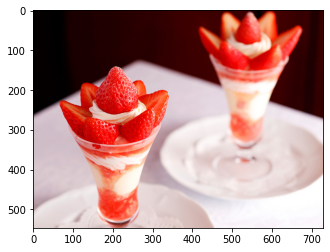

img.size: torch.Size([3, 224, 224])
x.size: torch.Size([1, 3, 224, 224])
y: tensor([[-1.0570,  0.6939]], grad_fn=<AddmmBackward0>)


<ipython-input-19-d2f6edf173fa>:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = torch.nn.functional.softmax(torch.squeeze(y))  # 確率で表す


[('strawberry', 0.8520758152008057), ('apple', 0.14792415499687195)]

In [19]:
##############
## Interference ##
##############


def predict(img):

    #クラスの定義
    classes = ["apple", "strawberry"]

    #画像の前処理
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(1.0,1.0)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    # モデルへの入力
    img = transform(img)
    x = torch.unsqueeze(img, 0)  # バッチ対応
    print(f"img.size: {img.shape}")
    print(f"x.size: {x.shape}")

    # 予測
    model_ft.eval()
    y = model_ft(x)
    print(f"y: {y}")

    # 結果を返す
    y_prob = torch.nn.functional.softmax(torch.squeeze(y))  # 確率で表す
    sorted_prob, sorted_indices = torch.sort(y_prob, descending=True)  # 降順にソート

    return [(classes[idx], prob.item()) for idx, prob in zip(sorted_indices, sorted_prob)]


#show image
img = Image.open("strawberry.jpg").convert('RGB')
plt.imshow(img)
plt.show()

#predict image
predict(img)[:2]
     

In [20]:
%%writefile model.py
# 以下を「model.py」に書き込み
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

classes = ["apple", "strawberry"]

def predict(img):
    transform = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]
                                        )
                                    ])

    model_ft = models.resnet18(pretrained=False)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)

    #学習済みモデルの読み込み
    model_ft.load_state_dict(torch.load("resnet18_applestra.pth", map_location=torch.device("cpu")))

    # モデルへの入力
    img = transform(img)
    x = torch.unsqueeze(img, 0)  # バッチ対応

    # 予測
    model_ft.eval()
    y = model_ft(x)

    # 結果を返す
    y_prob = torch.nn.functional.softmax(torch.squeeze(y))  # 確率で表す
    sorted_prob, sorted_indices = torch.sort(y_prob, descending=True)  # 降順にソート
    return [(classes[idx], prob.item()) for idx, prob in zip(sorted_indices, sorted_prob)]

Writing model.py


In [21]:
%%writefile app.py
# 以下を「app.py」に書き込み
import streamlit as st
import matplotlib.pyplot as plt
from PIL import Image
from model import predict

st.set_option("deprecation.showfileUploaderEncoding", False)

st.sidebar.title("画像認識アプリ")
st.sidebar.write("ResNetを使って何の画像かを判定します。")

st.sidebar.write("")

img_source = st.sidebar.radio("画像のソースを選択してください。",
                              ("画像をアップロード", "カメラで撮影"))
if img_source == "画像をアップロード":
    img_file = st.sidebar.file_uploader("画像を選択してください。", type=["png", "jpg"])
elif img_source == "カメラで撮影":
    img_file = st.camera_input("カメラで撮影")

sample_img = st.sidebar.radio("sample images", ["nil", "strawberry"])
if sample_img == "strawberry":
    img_file = "strawberry.jpg"

if img_file is not None:
    with st.spinner("推定中..."):
        img = Image.open(img_file).convert('RGB')
        st.image(img, caption="対象の画像", width=480)
        st.write("")

        # 予測
        results = predict(img)

        # 結果の表示
        st.subheader("判定結果")
        n_top = 5  # 確率が高い順に5位まで返す
        for result in results[:n_top]:
            st.write(str(round(result[1]*100, 2)) + "%の確率で" + result[0] + "です。")

        # 円グラフの表示
        pie_labels = [result[0] for result in results[:n_top]]
        pie_labels.append("others")
        pie_probs = [result[1] for result in results[:n_top]]
        pie_probs.append(sum([result[1] for result in results[n_top:]]))
        fig, ax = plt.subplots()
        wedgeprops={"width":0.3, "edgecolor":"white"}
        textprops = {"fontsize":6}
        ax.pie(pie_probs, labels=pie_labels, counterclock=False, startangle=90,
               textprops=textprops, autopct="%.2f", wedgeprops=wedgeprops)  # 円グラフ
        st.pyplot(fig)

Writing app.py


#**Localtunnelを用いたアプリ起動**

In [ ]:
from google.colab import files
files.view("/content")
files.view("app.py")
!streamlit run app.py & sleep 3 && npx localtunnel --port 8501

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2023-02-14 02:37:53.506 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.87.136.112:8501

npx: installed 22 in 1.881s
your url is: https://fresh-pandas-pump-34-87-136-112.loca.lt


# **実際にweb上にデプロイしてみよう**

## **準備**

### GitHubへの登録

- https://github.com/

- Create a new repository

- readmeにチェックを入れて作成する

### Streamlit Cloudへの登録

- https://streamlit.io/cloud

- GitHubのアカウントと関連づけて登録


## **アップロードするファイルの準備**

- app.py

- model.py

- モデルのファイル (resnet18_appkestra.pth)

- サンプル画像（strawberry.jpg)

- **requirements.txt** ←新たに作成

In [ ]:
# requirements.txtの作成
"""
Streamlit Cloudのサーバー上でアプリを動かすために、「requirements.txt」を作成する必要があります。
このファイルでは、必要なライブラリのバージョンを指定します。
"""

In [ ]:
#ライブラリのバージョン確認
import streamlit
import torch
import torchvision
import PIL
import matplotlib

print("streamlit==" + streamlit.__version__)
print("torch==" + torch.__version__)
print("torchvision==" + torchvision.__version__)
print("Pillow==" + PIL.__version__)
print("matplotlib==" + matplotlib.__version__)


In [ ]:
with open("requirements.txt", "w") as w:
    w.write("streamlit==1.8.1\n")  # Streamlit Cloud上で動作が確認できたバージョン
    w.write("torch==1.10.0\n")  # Cuda対応は要らないのでcu111は記述しない
    w.write("torchvision==0.11.1\n")  # Cuda対応は要らないのでcu111は記述しない
    w.write("Pillow==8.3.2\n") #Pillow==7.1.2では動作しなかったので最新バージョンに変更
    w.write("matplotlib==3.6.2\n") #Matplotlib==3.2.2では動作しなかったので最新バージョンに変更

In [ ]:
#必要ファイルを圧縮してダウンロードし、GitHubのリポジトリにアップロード
#→ Streamlit Cloudの　"New App"　からデプロイ

import zipfile
list_files = ["app.py", "model.py", "resnet18_applestra.pth", "requirements.txt", "strawberry.jpg"]

with zipfile.ZipFile('streamlit.zip', 'w') as zipF:
    for file in list_files:
        zipF.write(file, compress_type=zipfile.ZIP_DEFLATED)

print(f'The {len(list_files)} files has been compressed')

The 5 files has been compressed
